In [1]:
import os
os.getcwd()

'/home/yotamfr/development/prot2vec/src/python'

In [2]:
from src.python.digo import *

asp = 'F'
year = 2014

/home/yotamfr/development/prot2vec/virtualenv/lib/python3.6/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


In [3]:
%matplotlib inline
%load_ext autoreload   
%autoreload 2

import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

def plot_histograms(pos, neg, val_range, pos_label='same-leaf', neg_label='cousins'):
    plt.hist(pos, bins=100, alpha=0.8, label=pos_label, normed=1, cumulative=True, histtype='step', range=val_range)
    plt.hist(neg, bins=100, alpha=0.8, label=neg_label, normed=1, cumulative=True, histtype='step', range=val_range)
    plt.legend(loc='upper right')
    plt.title("Distribution of  bitscore")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [4]:
pos = load_object("../../Data/digo_%s_ks_pos_data_%d" % (GoAspect(asp), year))
neg = load_object("../../Data/digo_%s_ks_neg_data_%d" % (GoAspect(asp), year))

In [5]:
pos_bitscore = [h.bitscore for h in pos]
neg_bitscore = [h.bitscore for h in neg]

ks_2samp(pos_bitscore, neg_bitscore)

Ks_2sampResult(statistic=0.42820000000000003, pvalue=0.0)

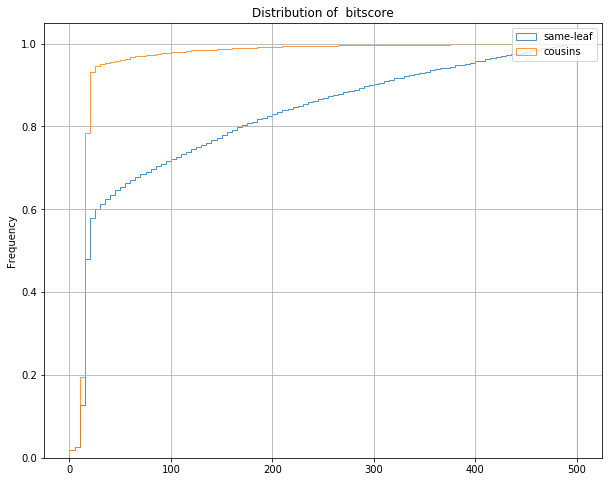

In [6]:
plot_histograms(pos_bitscore, neg_bitscore, (0, 500))

In [7]:
pos_pident = [h.pident for h in pos]
neg_pident = [h.pident for h in neg]

ks_2samp(pos_pident, neg_pident)

Ks_2sampResult(statistic=0.13350000000000006, pvalue=4.3016933400341578e-78)

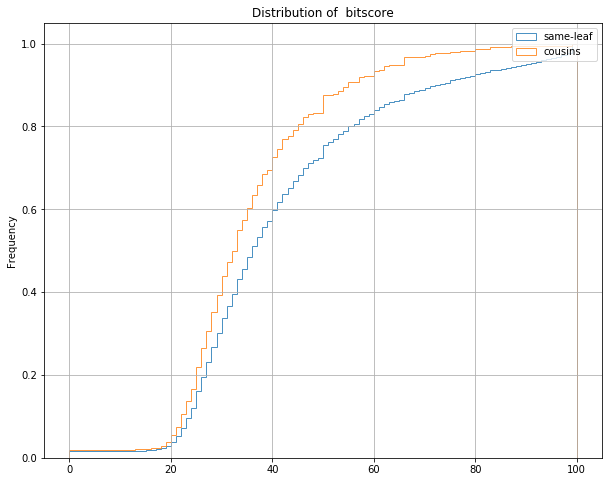

In [8]:
plot_histograms(pos_pident, neg_pident, (0, 100))

In [9]:
hits_per_uid = load_object("../../Data/blast_%s_hsp_%d" % (GoAspect(asp), year))
gt_per_uid = load_object("../../Data/gt_%s_%d" % (GoAspect(asp), year))
len(hits_per_uid), len(gt_per_uid)

(2893, 2893)

In [10]:
from digo import *
graph = load_object("../../Data/digo_%s_graph_%d" % (GoAspect(asp), year))
for node in graph: compute_node_prior(node, graph, grace=0.0)

In [11]:
def bar_plot_with_labels(data, labels):
    indx = range(1, len(data)+1)
    plt.bar(indx, data, align='center')
    plt.xticks(indx, labels)
    plt.xticks(rotation=90)
    plt.show()

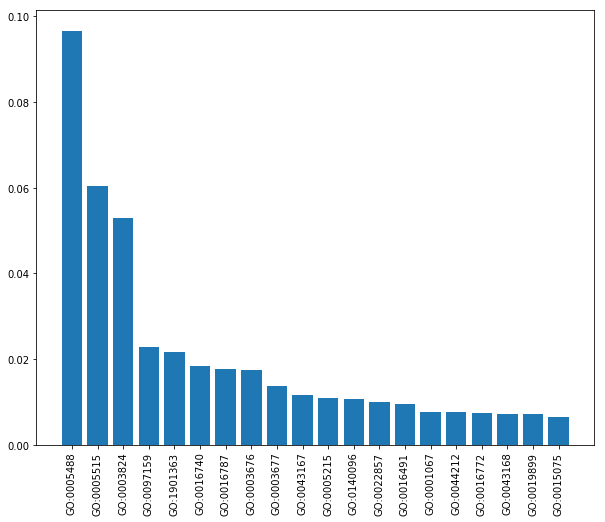

In [12]:
total_gt = sum([len(terms) for terms in gt_per_uid.values()])
reversed_gt = {}
for uid, terms in gt_per_uid.items():
    for go in terms:
        if go in reversed_gt:
            reversed_gt[go].append(uid)
        else:
            reversed_gt[go] = [uid]

gt_prior_arr = [(go, len(reversed_gt[go])/total_gt) for go in reversed_gt]
gt_prior_arr.sort(key=lambda pair: -pair[1])
labels, data = zip(*gt_prior_arr[:20])
bar_plot_with_labels(data, labels)

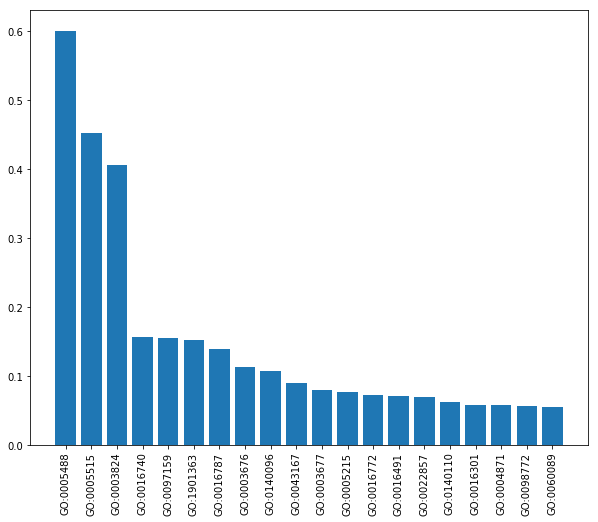

In [13]:
nodes_prior = {node.go: node.prior for node in graph}
del nodes_prior[graph.root.go]
nodes_prior_arr = list(nodes_prior.items())
nodes_prior_arr.sort(key=lambda pair: -pair[1])
    
labels, data = zip(*nodes_prior_arr[:20])
bar_plot_with_labels(data, labels)

In [14]:
import pandas as pd
from baselines import *

thresholds = [0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65]
preds_per_uid = {uid: nodes_prior for uid in hits_per_uid.keys()}
perf_naive = ths, prs, rcs, f1s = performance(preds_per_uid, gt_per_uid, ths=thresholds)
pd.DataFrame({"Threshold":ths, "Precision":prs, "Recall":rcs, "F1":f1s}).head(20)

,F1,Precision,Recall,Threshold
0,0.101411,0.054933,0.658830,0.02
1,0.191831,0.117249,0.527154,0.05
2,0.303822,0.235127,0.429223,0.10
3,0.337799,0.298767,0.388561,0.15
4,0.382398,0.448784,0.333121,0.20
5,0.382398,0.448784,0.333121,0.25
6,0.382398,0.448784,0.333121,0.30
7,0.382398,0.448784,0.333121,0.35
8,0.382398,0.448784,0.333121,0.40
9,0.351613,0.485482,0.275614,0.45


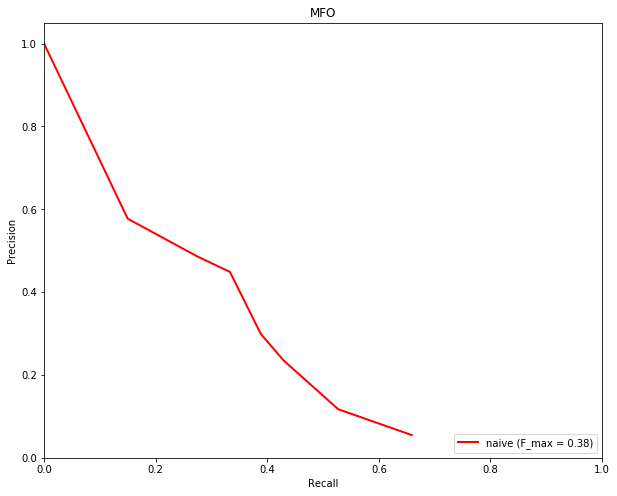

In [15]:
plot_precision_recall({"naive": perf_naive})

In [16]:
from digo import *
graph = load_object("../../Data/digo_%s_graph_%d" % (GoAspect(asp), year))
for node in graph: compute_node_prior(node, graph, grace=0.1)

In [17]:
def preds_by_attr(hits_per_uid, attr, nb=None):
    preds = {}
    pbar = tqdm(range(len(hits_per_uid)), desc="sequences processed")
    for uid, hits in hits_per_uid.items():
        pbar.update(1)
        if len(hits) == 0:
            continue
        preds[uid] = {}
        for go, hits in hits.items():
            assert go != graph.root.go
            hs =[getattr(h, attr) for h in hits if h.evalue < 0.001]
            if len(hs) == 0:
                continue
            if nb:
                preds[uid][go] = nb.infer(max(hs), graph[go].prior)
            else:
                preds[uid][go] = max(hs)
    pbar.close()
    return preds

def smart_infer(go2score, max_leaves=4):
    leaves = list(get_leaves([graph[go] for go in go2score.keys()]))
    leaves.sort(key=lambda node: go2score[node.go], reverse=True)
    fathers = {}
    for leaf in leaves[:max_leaves]:
        prop_set = digo.propagate(leaf)
        assert graph.root not in prop_set
        assert leaf in prop_set
        for father in prop_set:
            try:
                fathers[father.go] = max(go2score[leaf.go], go2score[father.go])
            except KeyError:
                fathers[father.go] = go2score[leaf.go]
    return fathers

In [18]:
import pandas as pd
from baselines import *

nb = NaiveBayes(Distribution(pos_bitscore), Distribution(neg_bitscore))

thresholds = [-5, -4.5, -4, -3.5, -3, -2.5, -2, -1, -0.5, 0.0, 0.5, 1.0, 1.5, 2]
preds_per_uid = preds_by_attr(hits_per_uid, "bitscore", nb)
# preds_per_uid = {uid: smart_infer(graph, go2score) for uid, go2score in preds_per_uid.items()}
perf_bitscore_nb = ths, prs, rcs, f1s = performance(preds_per_uid, gt_per_uid, ths=thresholds)
pd.DataFrame({"Threshold":ths, "Precision":prs, "Recall":rcs, "F1":f1s}).head(20)

sequences processed: 100%|██████████| 2893/2893 [01:47<00:00, 26.82it/s]


,F1,Precision,Recall,Threshold
0,0.483036,0.355319,0.754087,-5.0
1,0.482987,0.358007,0.742032,-4.5
2,0.484515,0.390486,0.638191,-4.0
3,0.504330,0.477697,0.534109,-3.5
4,0.518385,0.565392,0.478594,-3.0
5,0.493349,0.650567,0.397329,-2.5
6,0.465066,0.758492,0.335339,-2.0
7,0.414597,0.823668,0.277018,-1.0
8,0.396101,0.837368,0.259404,-0.5
9,0.296178,0.871544,0.178402,0.0


In [19]:
# import pandas as pd
# from baselines import *

# thresholds = [20, 25, 30, 40, 50, 75, 100, 150, 200, 250, 500, 750, 1000, 1250, 1500, 2000, 2500, 3000]
# preds_per_uid = preds_by_attr(hits_per_uid, "bitscore")
# smart_preds_per_uid = {uid: smart_infer(graph, preds) for uid, preds in preds_per_uid.items()}
# perf_bitscore = performance(preds_per_uid, gt_per_uid, ths=thresholds)
# perf_smart_bitscore = performance(smart_preds_per_uid, gt_per_uid, ths=thresholds)
# ths1, prs1, rcs1, f1s1 = perf_bitscore
# ths2, prs2, rcs2, f1s2 = perf_smart_bitscore
# pd.DataFrame({"Threshold":ths1, "Precision":prs1, "Recall":rcs1, "F1":f1s1,
#               "Threshold_smart":ths2, "Precision_smart":prs2, "Recall_smart":rcs2, "F1_smart":f1s2}).head(20)

In [20]:
import pandas as pd
from baselines import *

thresholds = [15, 20, 25, 30, 40, 50, 75, 100, 150, 200, 250, 500, 750, 1000, 1250, 1500, 2000, 2500, 3000]
preds_per_uid = preds_by_attr(hits_per_uid, "bitscore")
perf_bitscore = ths, prs, rcs, f1s = performance(preds_per_uid, gt_per_uid, ths=thresholds)
pd.DataFrame({"Threshold":ths, "Precision":prs, "Recall":rcs, "F1":f1s}).head(20)

sequences processed: 100%|██████████| 2893/2893 [00:03<00:00, 836.17it/s]


,F1,Precision,Recall,Threshold
0,0.483036,0.355319,0.754087,15
1,0.483036,0.355319,0.754087,20
2,0.483036,0.355319,0.754087,25
3,0.483036,0.355319,0.754087,30
4,0.483964,0.356655,0.752610,40
5,0.511507,0.397763,0.716356,50
6,0.556314,0.482970,0.655921,75
7,0.572498,0.546068,0.601617,100
8,0.569726,0.641213,0.512580,150
9,0.549064,0.694932,0.453809,200


In [21]:
# import pandas as pd
# from baselines import *
# thresholds = [25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 97, 99]
# preds_per_uid = preds_by_attr(hits_per_uid, "pident")
# smart_preds_per_uid = {uid: smart_infer(graph, preds) for uid, preds in preds_per_uid.items()}
# perf_pident = performance(preds_per_uid, gt_per_uid, ths=thresholds)
# perf_smart_pident = performance(smart_preds_per_uid, gt_per_uid, ths=thresholds)
# ths1, prs1, rcs1, f1s1 = perf_pident
# ths2, prs2, rcs2, f1s2 = perf_smart_pident
# pd.DataFrame({"Threshold":ths1, "Precision":prs1, "Recall":rcs1, "F1":f1s1,
#              "Threshold_smart":ths2, "Precision_smart":prs2, "Recall_smart":rcs2, "F1_smart":f1s2}).head(20)

In [44]:
import pandas as pd
from baselines import *

thresholds = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
preds_per_uid = preds_by_attr(hits_per_uid, "pident")
perf_pident = ths, prs, rcs, f1s = performance(preds_per_uid, gt_per_uid, ths=thresholds)
pd.DataFrame({"Threshold":ths, "Precision":prs, "Recall":rcs, "F1":f1s}).head(20)

sequences processed: 100%|██████████| 2893/2893 [00:03<00:00, 817.40it/s]


,F1,Precision,Recall,Threshold
0,0.483036,0.355319,0.754087,15
1,0.483393,0.355764,0.753828,20
2,0.500546,0.378258,0.739676,25
3,0.539997,0.446235,0.683641,30
4,0.566457,0.529046,0.609562,35
5,0.570589,0.613483,0.533301,40
6,0.555086,0.686787,0.465768,45
7,0.514175,0.740657,0.393767,50
8,0.460506,0.788010,0.325306,55
9,0.418604,0.818704,0.281188,60


In [23]:
# plot_precision_recall({"blast_bitscore": perf_bitscore, "blast_%identity": perf_pident,
#                       "smart_blast_bitscore": perf_smart_bitscore, "smart_blast_%identity": perf_smart_pident})

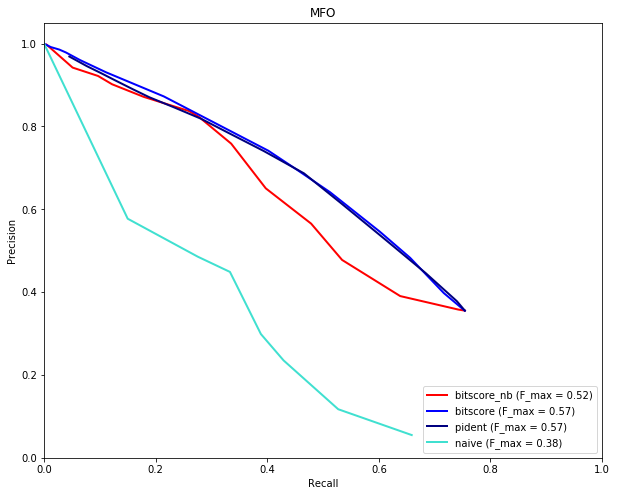

In [24]:
plot_precision_recall({"bitscore_nb": perf_bitscore_nb, "bitscore": perf_bitscore, 
                       "pident": perf_pident, "naive": perf_naive})

## Questions
1. If bitscore is such a good discriminator between sequences coming from the same node and sequences coming from cousins how come that it achieves equivalent results to percentage of idendity? 
2. Could I have higher precision w/o affecting the recall?

In [25]:
onto = get_ontology(asp)

In [26]:
def least_common_ancestor(G, go1, go2):
    ancestors1 = nx.shortest_path_length(G, source=go1)
    ancestors2 = nx.shortest_path_length(G, source=go2)
    common = list(set(ancestors1.keys()) & set(ancestors2.keys()))
    assert len(common) > 0
    c = common[np.argmin([ancestors1[c] + ancestors2[c] for c in common])]
    return c, ancestors1[c] + ancestors2[c]

wrong_hist = []
pbar = tqdm(range(len(hits_per_uid)), desc="sequences processed")
for uid, hits in hits_per_uid.items():
    pbar.update(1)
    if len(hits) == 0:
        continue
    for go, hits in hits.items():
        assert go != graph.root.go
        hs =[h for h in hits if h.evalue < 0.001]
        if len(hs) == 0:
            continue
        uid_annots = gt_per_uid[uid]
        if go in uid_annots:
            continue
        shortest = [least_common_ancestor(onto._graph, go, correct)[1] for correct in uid_annots]
        wrong_hist.extend(shortest)
pbar.close()

sequences processed: 100%|██████████| 2893/2893 [01:36<00:00, 29.86it/s]


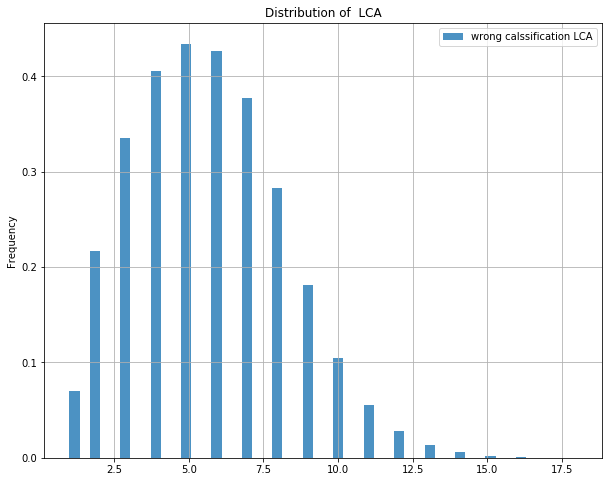

In [27]:
plt.hist(wrong_hist, bins=50, alpha=0.8, label="wrong calssification LCA", normed=1, cumulative=False)
plt.legend(loc='upper right')
plt.title("Distribution of  LCA")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [28]:
# from src.python.deepseq0 import *

# from keras.models import model_from_json

# client = MongoClient("mongodb://localhost:27017/")

# db = client['prot2vec']

# print("Loading Ontology...")
# onto = get_ontology(ASPECT)

# model_str_deeperseq = "deeperseq-20-0.00241-0.56"

# classes = onto.classes
# classes.remove(onto.root)
# assert onto.root not in classes

# with open('../../checkpoints/%s.json' % model_str_deeperseq, 'r') as f:
#     deeperseq = model_from_json(f.read())
    
# deeperseq.load_weights("../../checkpoints/%s.hdf5" % model_str_deeperseq)
# print("Loaded model from disk")

In [29]:
# query = {"_id": {"$in": list(gt_per_uid.keys())}}
# count = db.uniprot.count(query)
# source = db.uniprot.find(query).batch_size(10)
# stream_tst = DataStream(source, count, gt_per_uid, onto, classes)

In [30]:
# y_gt, y_ds = predict(deeperseq, batch_generator(stream_tst), len(stream_tst), classes)
# perf_deepseq = performance(y_ds, y_gt, classes)

In [31]:
# y_gt, y_dumb = predict_dummy(deeperseq, batch_generator(stream_tst), len(stream_tst), classes)
# perf_dummy = performance(y_ds, y_dumb, classes)

In [48]:
digo_preds_ks = load_object("../../Data/digo_F_preds_0.001_ks")

In [45]:
import pandas as pd
from baselines import *

thresholds = [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
perf_ks = ths, prs, rcs, f1s = performance(digo_preds_ks_blast, gt_per_uid, ths=thresholds)
pd.DataFrame({"Threshold":ths, "Precision":prs, "Recall":rcs, "F1":f1s}).head(20)

,F1,Precision,Recall,Threshold
0,0.464220,0.535325,0.409789,0.20
1,0.457826,0.543486,0.395491,0.25
2,0.451377,0.553819,0.380917,0.30
3,0.436414,0.565702,0.355229,0.35
4,0.429951,0.572747,0.344148,0.40
5,0.420306,0.584831,0.328025,0.45
6,0.413042,0.598023,0.315463,0.50
7,0.397914,0.613517,0.294441,0.55
8,0.388872,0.624899,0.282261,0.60
9,0.380629,0.638562,0.271118,0.65


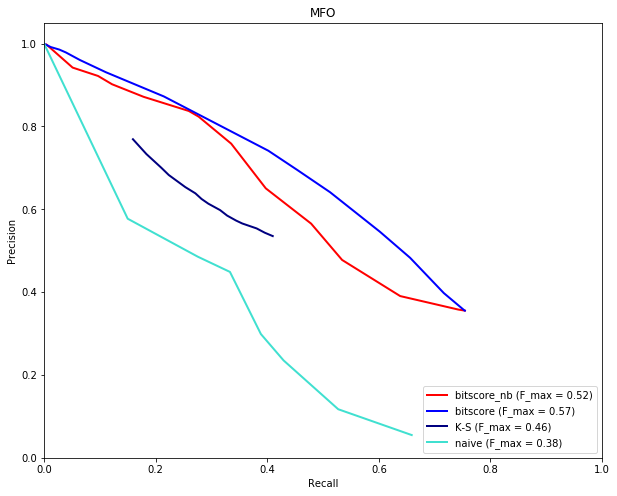

In [46]:
plot_precision_recall({"bitscore_nb": perf_bitscore_nb, "bitscore": perf_bitscore, "K-S": perf_ks, "naive": perf_naive})

In [50]:
predictions_pindent = preds_by_attr(hits_per_uid, "pident")

for tgt in gt_per_uid.keys():
    predictions = digo_preds_ks[tgt]
    for go, pident in predictions_pindent[tgt].items():
        prob = pident / 100
        if go in predictions:
            predictions[go] = 1 - (1 - prob) * (1 - predictions[go])
        else:
            predictions[go] = prob
    digo_preds_ks[tgt] = predictions

sequences processed: 100%|██████████| 2893/2893 [00:03<00:00, 836.26it/s]


In [51]:
import pandas as pd
from baselines import *

thresholds = [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
digo_preds_ks = ths, prs, rcs, f1s = performance(digo_preds_ks, gt_per_uid, ths=thresholds)
pd.DataFrame({"Threshold":ths, "Precision":prs, "Recall":rcs, "F1":f1s}).head(20)

,F1,Precision,Recall,Threshold
0,0.482687,0.354788,0.754778,0.20
1,0.482695,0.354798,0.754778,0.25
2,0.482696,0.354798,0.754778,0.30
3,0.482906,0.355026,0.754778,0.35
4,0.485101,0.358032,0.751988,0.40
5,0.495927,0.372239,0.742720,0.45
6,0.513436,0.398467,0.721652,0.50
7,0.526891,0.424648,0.693981,0.55
8,0.536449,0.450286,0.663388,0.60
9,0.543505,0.477003,0.631555,0.65


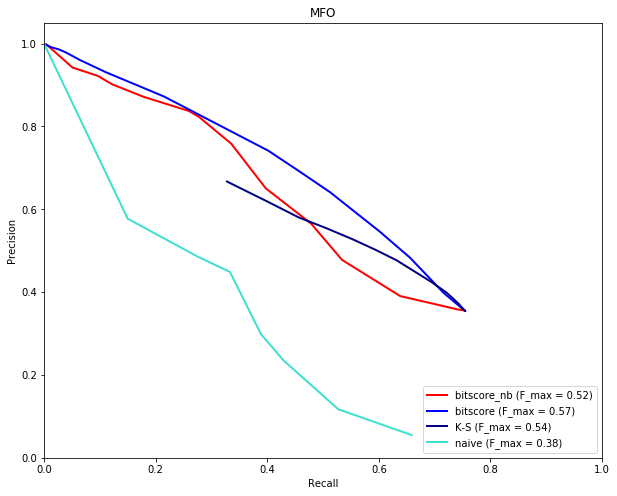

In [53]:
plot_precision_recall({"bitscore_nb": perf_bitscore_nb, "bitscore": perf_bitscore, "K-S": digo_preds_ks, "naive": perf_naive})